In [1]:
# pip install the cateye library from a bash command
#!pip install git+https://github.com/DiGyt/cateye.git -q

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cateye import (plot_segmentation, plot_trajectory,
                    classify_nslr_hmm, classify_remodnav,
                    discrete_to_continuous, continuous_to_discrete)
from cateye import sample_data_path

In [3]:
# load the data and events
df = pd.read_csv(sample_data_path("example_data"))
df.index = pd.to_timedelta(df["Timestamp"], unit="S")
df = df.sort_index()
df.head()

,Timestamp,Theta,Phi
Timestamp,,,
00:01:10.512291,70.512291,0.427579,0.284328
00:01:10.520691,70.520691,0.428165,0.283948
00:01:10.529091,70.529091,0.428584,0.283729
00:01:10.537491,70.537491,0.429152,0.282755
00:01:10.545891,70.545891,0.428907,0.282665


In [4]:
# interpolate constants
for col in ["Theta", "Phi"]:
    mask = [i in (0, 1) for i in df[col]]
    df[col][mask] = np.nan
df = df.interpolate()

# convert radian data format to degree
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].apply(np.rad2deg)

# Apply a median boxcar to our gaze data
boxcar_size = 3
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].rolling(boxcar_size).median()
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].fillna(method='backfill')

# crop the recording between 80 and 160 seconds
start = 80
stop = 160
df = df.loc[(df["Timestamp"] >= start) & (df["Timestamp"] <= stop)]

# resample to 200 Hz
sfreq = 200
df = df.resample(f"{1/sfreq}S").mean().interpolate()

In [5]:
event_df = pd.read_csv(sample_data_path("example_events"))
event_df.head()

,Timestamp,Name
0,70.48039,instruction
1,77.00052,biflicker
2,78.51971,biflicker
3,80.03895,biflicker
4,81.55901,biflicker


In [6]:
ev_idx, ev_names = discrete_to_continuous(df["Timestamp"], event_df["Timestamp"], event_df["Name"])
df["Event_Idx"] = ev_idx
df["Event_Name"] = ev_names
df.head()

,Timestamp,Theta,Phi,Event_Idx,Event_Name
Timestamp,,,,,
00:01:20.004291,80.004291,29.596364,19.183573,2.0,biflicker
00:01:20.009291,80.012691,29.596364,19.183573,2.0,biflicker
00:01:20.014291,80.016891,29.596364,19.183573,2.0,biflicker
00:01:20.019291,80.021091,29.596364,19.183573,2.0,biflicker
00:01:20.024291,80.025291,29.596364,19.183573,2.0,biflicker


In [7]:
# add NSLR-HMM classification
segments, classes = classify_nslr_hmm(df["Theta"], df["Phi"], df["Timestamp"], optimize_noise=False)
df["NSLR_Segment"] = segments
df["NSLR_Class"] = classes

In [8]:
# add remodnav class
segments, classes = classify_remodnav(df["Theta"], df["Phi"], df["Timestamp"], px2deg=1.,
                                      preproc_kwargs=dict(savgol_polyord=1), simple_output=True)
df["REMODNAV_Segment"] = segments
df["REMODNAV_Class"] = classes

In [9]:
df.head()

,Timestamp,Theta,Phi,Event_Idx,Event_Name,NSLR_Segment,NSLR_Class,REMODNAV_Segment,REMODNAV_Class
Timestamp,,,,,,,,,
00:01:20.004291,80.004291,29.596364,19.183573,2.0,biflicker,0.0,Fixation,0.0,Fixation
00:01:20.009291,80.012691,29.596364,19.183573,2.0,biflicker,0.0,Fixation,0.0,Fixation
00:01:20.014291,80.016891,29.596364,19.183573,2.0,biflicker,0.0,Fixation,0.0,Fixation
00:01:20.019291,80.021091,29.596364,19.183573,2.0,biflicker,0.0,Fixation,0.0,Fixation
00:01:20.024291,80.025291,29.596364,19.183573,2.0,biflicker,0.0,Fixation,0.0,Fixation


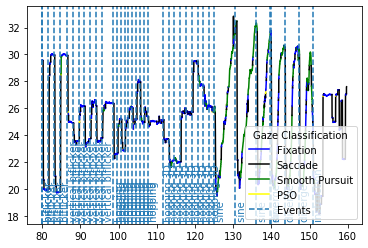

In [10]:
dis_seg_class = continuous_to_discrete(df["Timestamp"], df["REMODNAV_Segment"], df["REMODNAV_Class"])
dis_events = continuous_to_discrete(df["Timestamp"], df["Event_Idx"], df["Event_Name"])
plot_segmentation(df["Theta"], df["Timestamp"], dis_seg_class, dis_events);

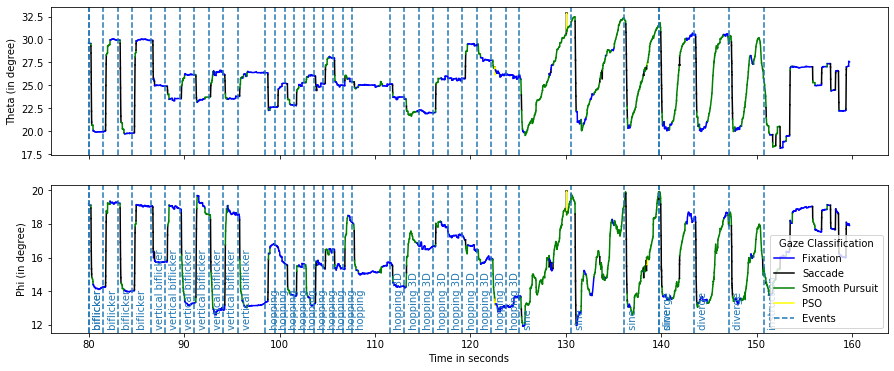

In [11]:
dis_seg_class = continuous_to_discrete(df["Timestamp"],
                                       df["NSLR_Segment"],
                                       df["NSLR_Class"])
dis_events = continuous_to_discrete(df["Timestamp"], df["Event_Idx"],
                                    df["Event_Name"])

fig, axes = plt.subplots(2, figsize=(15, 6), sharex=True)
        
plot_segmentation(df["Theta"], df["Timestamp"], dis_seg_class, dis_events, show_event_text=False, 
                  show_legend=False, ax=axes[0])
plot_segmentation(df["Phi"], df["Timestamp"], dis_seg_class, dis_events, ax=axes[1])

axes[0].set_ylabel("Theta (in degree)")
axes[1].set_ylabel("Phi (in degree)")
axes[1].set_xlabel("Time in seconds");

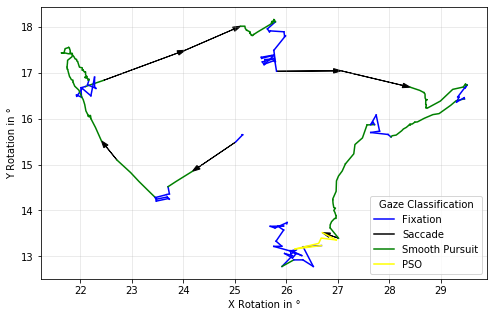

In [12]:
mask = df["Event_Name"] == "hopping 3D"
segments = continuous_to_discrete(df["Timestamp"], df["NSLR_Segment"], df["NSLR_Class"])


plt.figure(figsize=(8, 5))
plot_trajectory(df[mask]["Theta"], df[mask]["Phi"], df[mask]["Timestamp"], segments,
                show_legend=True, show_dots=False, show_clean=True, show_arrows=True,
                color_dict=None, ax=None, plot_kwargs=dict(linestyle="-"),
                dot_kwargs=dict(marker="."))
plt.grid(alpha=0.3)
plt.xlabel("X Rotation in °")
plt.ylabel("Y Rotation in °");

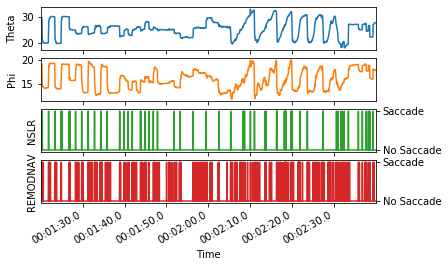

In [13]:
df["NSLR_SP"] = (df["NSLR_Class"] == "Saccade") * 1
df["REMODNAV_SP"] = (df["REMODNAV_Class"] == "Saccade") * 1
axes = df[["Theta", "Phi", "NSLR_SP", "REMODNAV_SP"]].plot(subplots=True, legend=False)


axes[2].yaxis.tick_right()
axes[2].set_yticklabels([0, "No Saccade", "Saccade"])
axes[3].yaxis.tick_right()
axes[3].set_yticklabels([0, "No Saccade", "Saccade"])
axes[0].set_ylabel("Theta")
axes[1].set_ylabel("Phi")
axes[2].set_ylabel("NSLR")
axes[3].set_ylabel("REMODNAV")
plt.xlabel("Time");

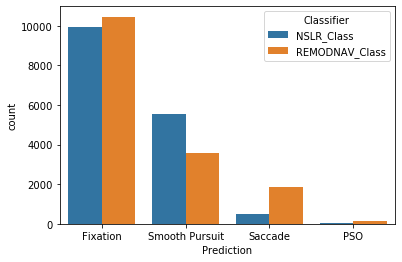

In [14]:
df_melt = df[["NSLR_Class", "REMODNAV_Class"]].melt(var_name="Classifier",
                                                    value_name="Prediction")
sns.countplot(x="Prediction", hue="Classifier", data=df_melt);

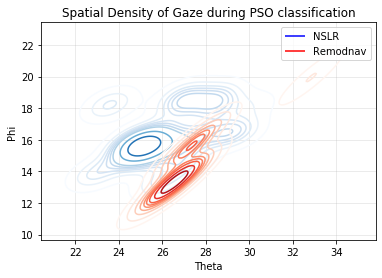

In [15]:
mask = df["REMODNAV_Class"] == "PSO"
sns.kdeplot(df[mask]["Theta"], df[mask]["Phi"], color='b',
            shade=False, cmap="Blues", shade_lowest=False)

mask = df["NSLR_Class"] == "PSO"
sns.kdeplot(df[mask]["Theta"], df[mask]["Phi"], color='b',
            shade=False, cmap="Reds", shade_lowest=False)

plt.title("Spatial Density of Gaze during PSO classification")
leg = plt.legend(["NSLR", "Remodnav"])
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
plt.grid(alpha=0.3);

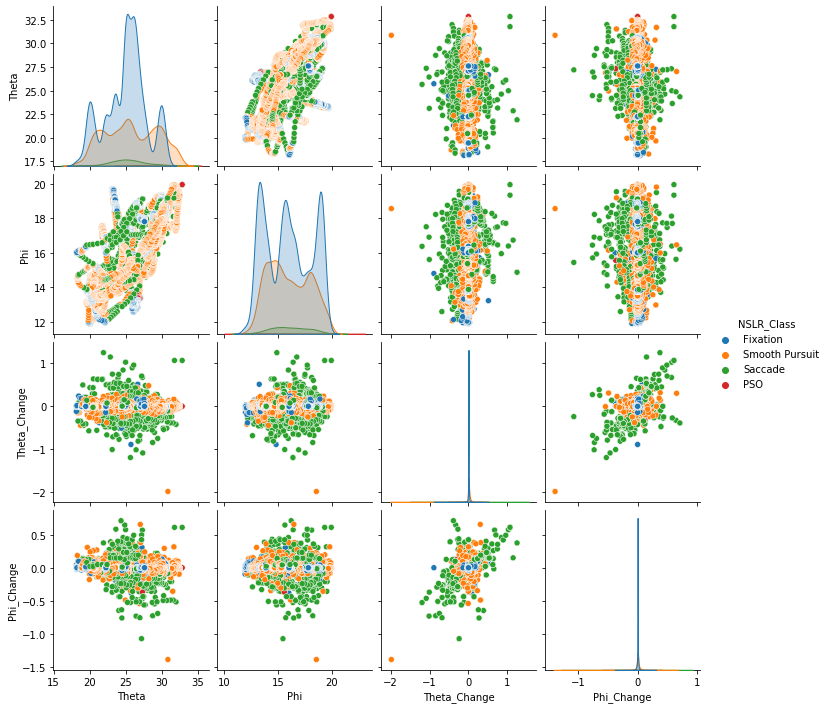

In [16]:
df["Theta_Change"] = df["Theta"] - df["Theta"].shift()
df["Phi_Change"] = df["Phi"] - df["Phi"].shift()
sns.pairplot(df[["Theta", "Phi", "Theta_Change", "Phi_Change", "NSLR_Class"]],
             hue="NSLR_Class");